In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 0

# Parameters common to both experiments
Exps = [{'N': 64, 'p': 0.7, 'q': 0.05},
        {'N': 128, 'p': 0.7, 'q': 0.05},
        {'N': 256, 'p': 0.7, 'q': 0.05},
        {'N': 512, 'p': 0.7, 'q': 0.05},
        {'N': 128, 'p': 0.5, 'q': 0.01},
        {'N': 256, 'p': 0.25, 'q': 0.005},
        {'N': 512, 'p': 0.25, 'q': 0.005}]

# Signal parameters
K = 3
n_signals = 100
params = 4
n_p = 0.1

# Model parameters
fts = 500  # 150
epochs = 500
lr = 0.001

## Graph Fixed

In [2]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
G_params = {}
G_params['type'] = ds.SBM
G_params['k'] = 4
G_params['type_z'] = ds.CONT

# Create graphs and filters
hs = np.random.rand(K)
hs /= np.sum(hs)

Graphs = []
legend = []
Hs = []
for exp in Exps:
    G_params['N'] = exp['N']
    G_params['p'] = exp['p']
    G_params['q'] = exp['q']
    G = ds.create_graph(G_params, SEED)
    Graphs.append(G)
    dense = G.Ne*2/(G.N*(G.N-1))
    print('Graph density:', dense)
    
    x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
    Hs.append(x_dw.H/np.linalg.norm(x_dw.H))
        
    legend.append('N: {} ({:.2f}) p: {} q: {}'
                  .format(G.N, dense, exp['p'], exp['q']))


Graph density: 0.20188492063492064
Graph density: 0.21186023622047245
Graph density: 0.2126531862745098
Graph density: 0.210669948630137
Graph density: 0.1311515748031496
Graph density: 0.06571691176470588
Graph density: 0.0665132705479452


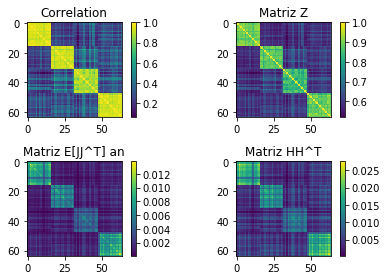

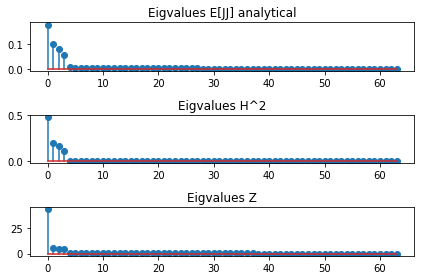

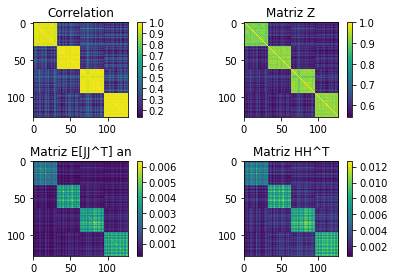

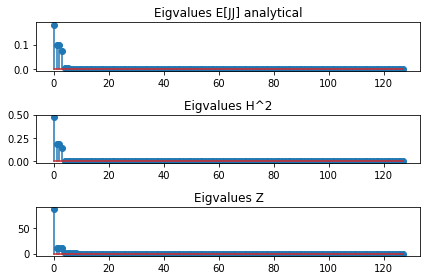

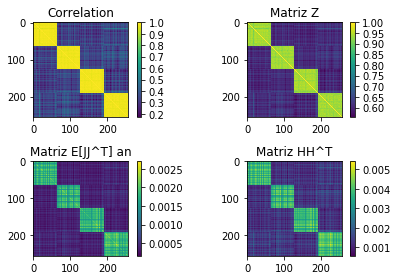

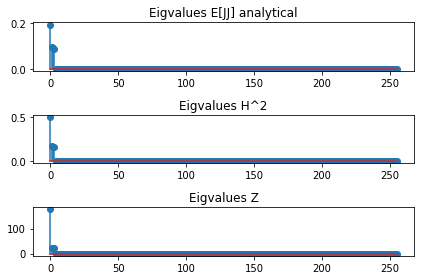

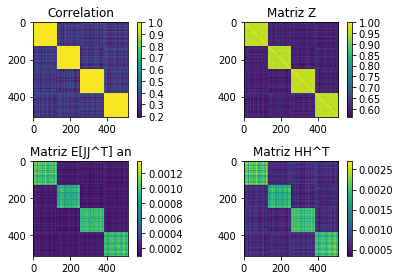

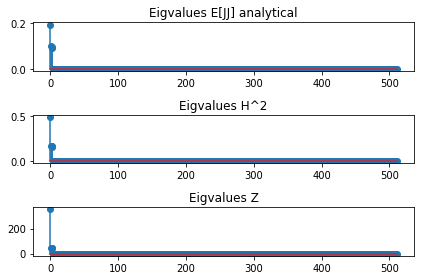

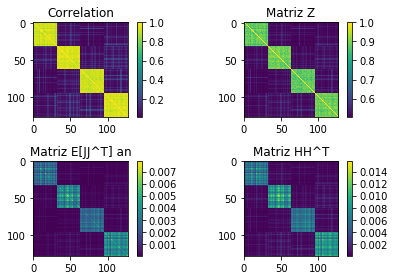

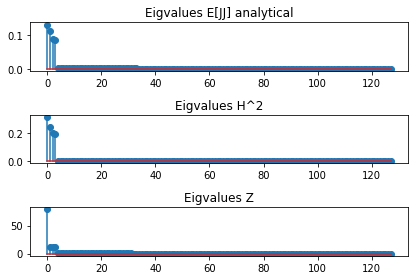

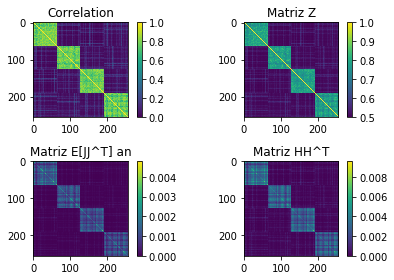

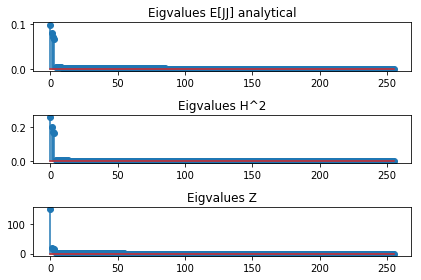

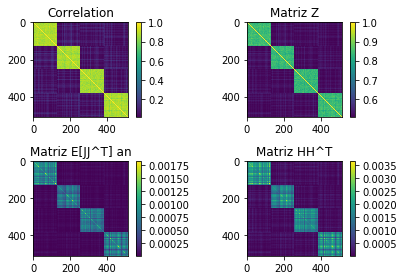

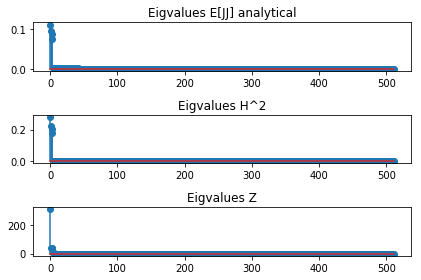

In [3]:
for i, G in enumerate(Graphs):
    H2 = Hs[i].dot(Hs[i])
    H_norm = Hs[i]/np.linalg.norm(Hs[i], axis=0)
    H2_norm = H_norm.T.dot(H_norm)
    H2_norm[H2_norm>1]=1

    Z = 1-np.arccos(H2_norm)/np.pi
    E_JJ_an = 0.5*Z*(H2)

    # Get eigendecomposition
    L_H, V_H = utils.ordered_eig(Hs[i])
    L_Z, V_Z = utils.ordered_eig(Z)
    V_Z = utils.choose_eig_sign(V_Z, V_H)
    L_E_JJ_an, V_E_JJ_an = utils.ordered_eig(E_JJ_an)
    V_E_JJ_an = utils.choose_eig_sign(V_E_JJ_an, V_H)
    
    # Plot matrices
    plt.figure()
    plt.subplot(221)
    plt.imshow(H2_norm)
    plt.colorbar()
    plt.title('Correlation')
    plt.subplot(222)
    plt.imshow(Z)
    plt.colorbar()
    plt.title('Matriz Z')
    plt.subplot(223)
    plt.imshow(E_JJ_an)
    plt.colorbar()
    plt.title('Matriz E[JJ^T] an')
    plt.subplot(224)
    plt.imshow(H2)
    plt.colorbar()
    plt.title('Matriz HH^T')
    plt.tight_layout()
    
    # Compare eigenvalues
    plt.figure()
    plt.subplot(311)
    plt.stem(L_E_JJ_an)
    plt.title('Eigvalues E[JJ] analytical')
    plt.subplot(312)
    plt.stem(L_H**2)
    plt.title('Eigvalues H^2')
    plt.subplot(313)
    plt.stem(L_Z)
    plt.title('Eigvalues Z')
    plt.tight_layout()

In [4]:
err = np.zeros((len(Exps), n_signals, epochs))
err_wrt_n = np.zeros((len(Exps), n_signals, epochs))
weight_norm = np.zeros((len(Exps), n_signals))
start_time = time.time()
for i in range(n_signals):
    for j, H in enumerate(Hs):
        dec = GraphDecoder(fts, H)
        weight_norm[j, i] = np.linalg.norm(dec.conv.weight.data.numpy().squeeze())
                
        Lambda, V = utils.ordered_eig(H)
        x = ds.bandlimited_signal(Lambda, V, params)
        x_n = ds.GraphSignal.add_noise(x, n_p)
        model = Model(dec, epochs=epochs, learning_rate=lr)
        err_wrt_n[j, i, :], err[j, i, :], _ = model.fit(x_n, x)

    print('Signal', i, 'done')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

Signal 0 done
Signal 1 done
Signal 2 done
Signal 3 done
Signal 4 done
Signal 5 done
Signal 6 done
Signal 7 done
Signal 8 done
Signal 9 done
Signal 10 done
Signal 11 done
Signal 12 done
Signal 13 done
Signal 14 done
Signal 15 done
Signal 16 done
Signal 17 done
Signal 18 done
Signal 19 done
Signal 20 done
Signal 21 done
Signal 22 done
Signal 23 done
Signal 24 done
Signal 25 done
Signal 26 done
Signal 27 done
Signal 28 done
Signal 29 done
Signal 30 done
Signal 31 done
Signal 32 done
Signal 33 done
Signal 34 done
Signal 35 done
Signal 36 done
Signal 37 done
Signal 38 done
Signal 39 done
Signal 40 done
Signal 41 done
Signal 42 done
Signal 43 done
Signal 44 done
Signal 45 done
Signal 46 done
Signal 47 done
Signal 48 done
Signal 49 done
Signal 50 done
Signal 51 done
Signal 52 done
Signal 53 done
Signal 54 done
Signal 55 done
Signal 56 done
Signal 57 done
Signal 58 done
Signal 59 done
Signal 60 done
Signal 61 done
Signal 62 done
Signal 63 done
Signal 64 done
Signal 65 done
Signal 66 done
Signa

[0.22351561 0.22355746 0.22367063 0.22362133 0.2235096  0.22361558
 0.22362307]


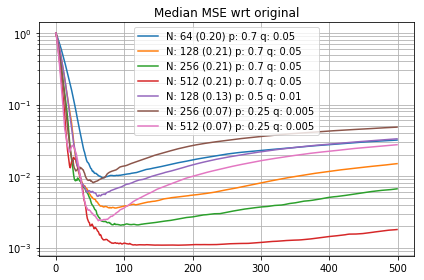

In [5]:
print(np.mean(weight_norm, axis=1))

# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

## Random Graphs

In [6]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Common graph parameters
G_params = {}
G_params['type'] = ds.SBM
G_params['k'] = 4
G_params['type_z'] = ds.CONT

legend = []
Gs = []
for exp in Exps:
    G_params = {}
    G_params['type'] = ds.SBM
    G_params['k'] = 4
    G_params['type_z'] = ds.CONT
    G_params['N'] = exp['N']
    G_params['p'] = exp['p']
    G_params['q'] = exp['q']
    Gs.append(G_params)

In [7]:
err = np.zeros((len(Exps), n_signals, epochs))
err_wrt_n = np.zeros((len(Exps), n_signals, epochs))
weight_norm = np.zeros((len(Exps), n_signals))
edges = np.zeros((len(Exps), n_signals))
start_time = time.time()
seed = SEED
for i in range(n_signals):
    hs = np.random.rand(K)
    hs /= np.sum(hs)
    for j, G_param in enumerate(Gs):
        G = ds.create_graph(G_param, seed)    
        H = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs).H
        H /= np.linalg.norm(H)
        edges[j, i] = G.Ne

        dec = GraphDecoder(fts, H)
        weight_norm[j, i] = np.linalg.norm(dec.conv.weight.data.numpy().squeeze())
        
        Lambda, V = utils.ordered_eig(H)
        x = ds.bandlimited_signal(Lambda, V, params)
        
        x_n = ds.GraphSignal.add_noise(x, n_p)
        model = Model(dec, epochs=epochs, learning_rate=lr)
        err_wrt_n[j, i, :], err[j, i, :], _ = model.fit(x_n, x)

    seed += 1
    print('Signal', i, 'done')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

Signal 0 done
Signal 1 done
Signal 2 done
Signal 3 done
Signal 4 done
Signal 5 done
Signal 6 done
Signal 7 done
Signal 8 done
Signal 9 done
Signal 10 done
Signal 11 done
Signal 12 done
Signal 13 done
Signal 14 done
Signal 15 done
Signal 16 done
Signal 17 done
Signal 18 done
Signal 19 done
Signal 20 done
Signal 21 done
Signal 22 done
Signal 23 done
Signal 24 done
Signal 25 done
Signal 26 done
Signal 27 done
Signal 28 done
Signal 29 done
Signal 30 done
Signal 31 done
Signal 32 done
Signal 33 done
Signal 34 done
Signal 35 done
Signal 36 done
Signal 37 done
Signal 38 done
Signal 39 done
Signal 40 done
Signal 41 done
Signal 42 done
Signal 43 done
Signal 44 done
Signal 45 done
Signal 46 done
Signal 47 done
Signal 48 done
Signal 49 done
Signal 50 done
Signal 51 done
Signal 52 done
Signal 53 done
Signal 54 done
Signal 55 done
Signal 56 done
Signal 57 done
Signal 58 done
Signal 59 done
Signal 60 done
Signal 61 done
Signal 62 done
Signal 63 done
Signal 64 done
Signal 65 done
Signal 66 done
Signa

[0.22351561 0.22355746 0.22367063 0.22362133 0.2235096  0.22361558
 0.22362307]


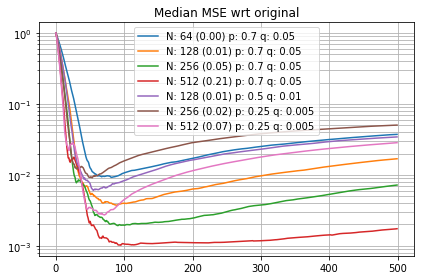

In [8]:
print(np.mean(weight_norm, axis=1))

# Create legend
mean_edges = np.mean(edges, axis=1)
legend  = []
for i, exp in enumerate(Exps):
    dense = mean_edges[i]*2/(G.N*(G.N-1))
    legend.append('N: {} ({:.2f}) p: {} q: {}'
                  .format(exp['N'], dense, exp['p'], exp['q']))

# Plots Median Error
med_mse = np.median(err, axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(legend)
plt.title('Median MSE wrt original')
plt.tight_layout()

In [9]:
plt.show()